## isgri_image

First load the Crab count rates file, which was acquired in CrabLongTerm.ipynb

In [42]:
import numpy as np

input_filename = "../data/crab_longterm_img_data_15_30_new.txt"

data = np.genfromtxt(input_filename, delimiter=",", dtype=None, names=True, encoding=None)

mask = ~np.isnan(data["Count_Rate"]) & (data["Count_Rate"] > 0) & (data["Annular_Variance"] > 0)

def mask_data(data):
    return np.array(data)[mask]

crab_countrates = mask_data(data["Count_Rate"])
crab_variances = mask_data(data["Variance"])
errors = np.sqrt(crab_variances)
offsets = mask_data(data["Angular_offset"])
annular_counts = mask_data(data["Annular_Count_Rate"])
annular_variances = mask_data(data["Annular_Variance"])
annular_errors = np.sqrt(annular_variances)
psf_counts = mask_data(data["PSF_Count_Rate"])
psf_errors = mask_data(data["PSF_Count_Rate_Error"])
fixed_psf_counts = mask_data(data["PSF_Count_Rate_Fixed"])
fixed_psf_errors = mask_data(data["PSF_Count_Rate_Error_Fixed"])
obs_start_dates = mask_data(data["Obs_Start_Date"])
obs_end_dates = mask_data(data["Obs_End_Date"])

Do some plotting

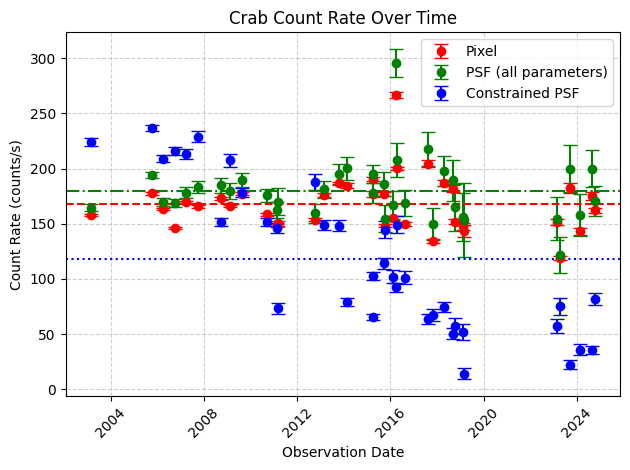

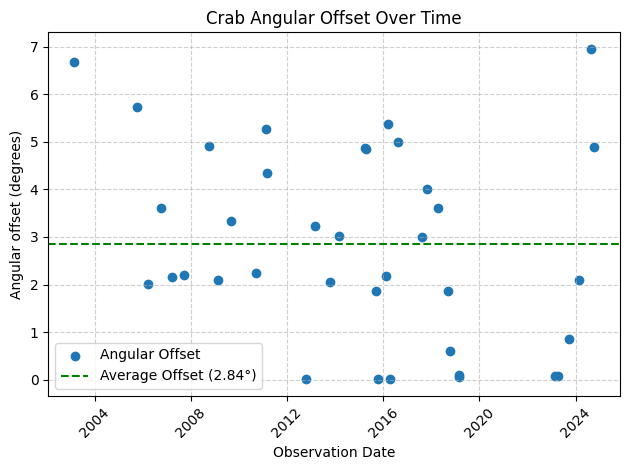

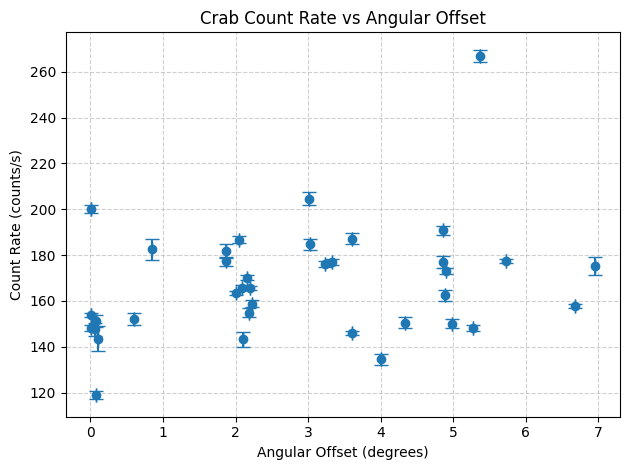

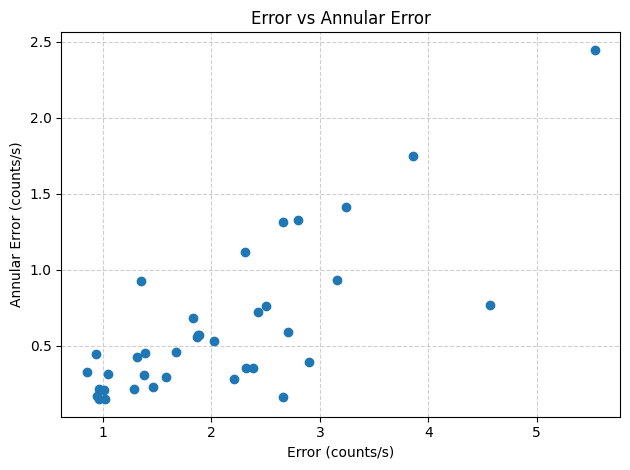

In [43]:
from datetime import datetime
import matplotlib.pyplot as plt

obs_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in obs_start_dates]

# Calculate average and standard deviation
avg_count_rate = np.mean(crab_countrates)
std_count_rate = np.std(crab_countrates)
avg_psfs = np.mean(psf_counts)
std_psfs = np.std(psf_counts)
avg_fixed_psfs = np.mean(fixed_psf_counts)
std_fixed_psfs = np.std(fixed_psf_counts)

avg_offset = np.mean(offsets)
std_offset = np.std(offsets)

# Plot count rate over time with errorbars and std region
plt.figure()
plt.errorbar(obs_times, crab_countrates, yerr=errors, color='r', fmt='o', capsize=5, label='Pixel')
plt.errorbar(obs_times, psf_counts, yerr=psf_errors, color='g', fmt='o', capsize=5, label='PSF (all parameters)')
plt.errorbar(obs_times, fixed_psf_counts, yerr=fixed_psf_errors, color='b', fmt='o', capsize=5, label='Constrained PSF')
plt.axhline(avg_count_rate, color='r', linestyle='--')
plt.axhline(avg_psfs, color='g', linestyle='-.')
plt.axhline(avg_fixed_psfs, color='b', linestyle=':')
#plt.fill_between(obs_times, avg_count_rate - std_count_rate, avg_count_rate + std_count_rate, color='r', alpha=0.2, label=f'Standard Deviation ({std_count_rate:.2f})')
plt.xlabel("Observation Date")
plt.ylabel("Count Rate (counts/s)")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot angular offset from pointing center over time with std region
plt.figure()
plt.scatter(obs_times, offsets, label='Angular Offset')
plt.axhline(avg_offset, color='g', linestyle='--', label=f'Average Offset ({avg_offset:.2f}°)')
#plt.fill_between(obs_times, avg_offset - std_offset, avg_offset + std_offset, color='g', alpha=0.2, label=f'Standard Deviation ({std_offset:.2f}°)')
plt.xlabel("Observation Date")
plt.ylabel("Angular offset (degrees)")
plt.title("Crab Angular Offset Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot count rate vs angular offset
plt.figure()
plt.errorbar(offsets, crab_countrates, xerr=0, yerr=errors, fmt='o', capsize=5)
plt.xlabel("Angular Offset (degrees)")
plt.ylabel("Count Rate (counts/s)")
plt.title("Crab Count Rate vs Angular Offset")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Plot error vs annular error
plt.figure()
plt.errorbar(errors, annular_errors, fmt='o', capsize=5)
plt.xlabel("Error (counts/s)")
plt.ylabel("Annular Error (counts/s)")
plt.title("Error vs Annular Error")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()


Calculate weighted mean

Weighted Crab Count Rate: 164.63 +- 0.25
Weighted PSF Count Rate: 178.98 +- 1.20
Weighted Constrained PSF Count Rate: 127.83 +- 0.73
18


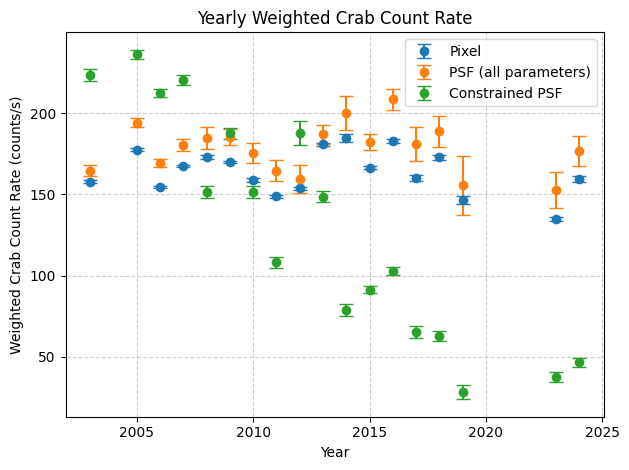

In [54]:
from collections import defaultdict

weights=1/crab_variances
psf_weights=1/psf_errors**2
fixed_psf_weights=1/fixed_psf_errors**2

# Total weighted average
weighted_crab_countrate = np.average(crab_countrates, weights=weights)
weighted_crab_countrate_std = np.sqrt(1 / np.sum(weights))
print(f"Weighted Crab Count Rate: {weighted_crab_countrate:.2f} +- {weighted_crab_countrate_std:.2f}")

weighted_psf_countrate = np.average(psf_counts, weights=psf_weights)
weighted_psf_countrate_std = np.sqrt(1 / np.sum(psf_weights))
print(f"Weighted PSF Count Rate: {weighted_psf_countrate:.2f} +- {weighted_psf_countrate_std:.2f}")

weighted_fixed_psf_countrate = np.average(fixed_psf_counts, weights=fixed_psf_weights)
weighted_fixed_psf_countrate_std = np.sqrt(1 / np.sum(fixed_psf_weights))
print(f"Weighted Constrained PSF Count Rate: {weighted_fixed_psf_countrate:.2f} +- {weighted_fixed_psf_countrate_std:.2f}")

# Yearly weighted average
yearly_data = defaultdict(list)
yearly_data_psf = defaultdict(list)
yearly_data_fixed_psf = defaultdict(list)

for date, count_rate, weight in zip(obs_times, crab_countrates, weights):
    year = date.year
    yearly_data[year].append((count_rate, weight))

for date, count_rate, weight in zip(obs_times, psf_counts, psf_weights):
    year = date.year
    yearly_data_psf[year].append((count_rate, weight))

for date, count_rate, weight in zip(obs_times, fixed_psf_counts, fixed_psf_weights):
    year = date.year
    yearly_data_fixed_psf[year].append((count_rate, weight))

yearly_weighted_means = {}
yearly_weighted_stds = {}
yearly_weighted_means_psf = {}
yearly_weighted_stds_psf = {}
yearly_weighted_means_fixed_psf = {}
yearly_weighted_stds_fixed_psf = {}

for year, values in yearly_data.items():
    count_rates, year_weights = zip(*values)
    count_rates = np.array(count_rates)
    year_weights = np.array(year_weights)
    yearly_weighted_means[year] = np.average(count_rates, weights=year_weights)
    yearly_weighted_stds[year] = np.sqrt(1 / np.sum(year_weights))

for year, values in yearly_data_psf.items():
    count_rates, year_weights = zip(*values)
    count_rates = np.array(count_rates)
    year_weights = np.array(year_weights)
    yearly_weighted_means_psf[year] = np.average(count_rates, weights=year_weights)
    yearly_weighted_stds_psf[year] = np.sqrt(1 / np.sum(year_weights))

for year, values in yearly_data_fixed_psf.items():
    count_rates, year_weights = zip(*values)
    count_rates = np.array(count_rates)
    year_weights = np.array(year_weights)
    yearly_weighted_means_fixed_psf[year] = np.average(count_rates, weights=year_weights)
    yearly_weighted_stds_fixed_psf[year] = np.sqrt(1 / np.sum(year_weights))

plt.figure()
plt.errorbar(list(yearly_weighted_means.keys()), list(yearly_weighted_means.values()), yerr=list(yearly_weighted_stds.values()), fmt='o', capsize=5, label='Pixel')
plt.errorbar(list(yearly_weighted_means_psf.keys()), list(yearly_weighted_means_psf.values()), yerr=list(yearly_weighted_stds_psf.values()), fmt='o', capsize=5, label='PSF (all parameters)')
plt.errorbar(list(yearly_weighted_means_fixed_psf.keys()), list(yearly_weighted_means_fixed_psf.values()), yerr=list(yearly_weighted_stds_fixed_psf.values()), fmt='o', capsize=5, label='Constrained PSF')
plt.xlabel("Year")
plt.ylabel("Weighted Crab Count Rate (counts/s)")
plt.title("Yearly Weighted Crab Count Rate")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

print(len(list(yearly_weighted_means.values())))

Flux conversion

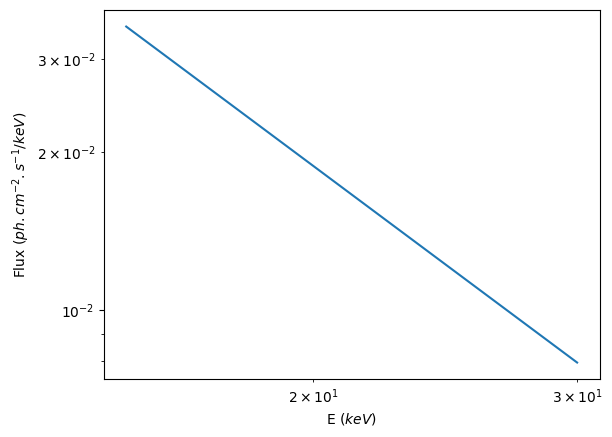

In [51]:
E0 = 100 # 100 keV reference energy
K = 6.2e-4 # flux @ 100 keV (photons/cm2/s), roughly the same for each instrument
E = np.linspace(15, 30)
gamma = 2.12 # photon index of ISGRI (2.105 for SPI+ISGRI+JEM-X)

power_law = K * (E/E0)**(-gamma) # flux

ph_flux = - K * (E0)**(gamma) / (gamma-1) * ((30)**(1-gamma) - (15)**(1-gamma)) # analytic
ph_flux_num = np.trapz(power_law, E) # numeric
ph_flux_num_erg = np.trapz(power_law*E*1.60218e-9, E) # numeric, energy units

plt.figure()
plt.loglog(E, power_law)
plt.xlabel('E ($keV$)')
plt.ylabel('Flux ($ph.cm^{-2}.s^{-1}/keV$)')

# Calculate yearl conversion factor
yearly_conversion_factors = ph_flux_num/list(yearly_weighted_means.values())
yearly_conversion_factors_erg = ph_flux_num_erg/list(yearly_weighted_means.values())

yearly_conversion_factors_std = ph_flux_num/list(yearly_weighted_stds.values())
yearly_conversion_factors_erg_std = ph_flux_num_erg/list(yearly_weighted_stds.values())

Save the yearly conversion factors to a file, which we will use for Jupiter

In [59]:
output_file = f"../data/yearly_conversion_factors_15_30.txt"
conversions = np.column_stack([list(yearly_weighted_means.keys()), yearly_conversion_factors, yearly_conversion_factors_std, yearly_conversion_factors_erg, yearly_conversion_factors_erg_std])
head = "Year, Conversion Factor (ph/cm2/s/counts), Conversion Factor Error (ph/cm2/s/counts), Conversion Factor (erg/cm2/s/counts), Conversion Factor Error (erg/cm2/s/counts)"

np.savetxt(output_file, conversions, fmt="%s", delimiter=",", header=head, comments="")
print(f"Data saved to {output_file}")

Data saved to ../data/yearly_conversion_factors_15_30.txt


## isgri_lc data

Load the data

In [ ]:
lc_input_filename = "../data/crab_longterm_lc_data.txt"

lc_data = np.genfromtxt(lc_input_filename, delimiter=",", dtype=None, names=True, encoding=None)

lc_obs_start_dates = data["Obs_Start_Date"]
lc_obs_end_dates = data["Obs_End_Date"]
crab_lc_countrates = data["Count_Rate"]
crab_lc_errors = data["Error"]

Plotting

In [ ]:
lc_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in lc_obs_start_dates]

lc_rates = np.array(crab_lc_countrates)
lc_err = np.array(crab_lc_errors)

plt.figure()
plt.errorbar(lc_times, lc_rates, yerr=lc_err, fmt='o', capsize=5, label="Crab Count Rate")
plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

## Comparison

In [ ]:
plt.figure()

plt.errorbar(obs_times, crab_countrates, yerr=errors, fmt='o', capsize=5, label="Images")
plt.errorbar(lc_times, lc_rates, yerr=lc_err, fmt='o', capsize=5, label="Light curves")

plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()